# Автоматическое определение границ заставок и титров

**Цель** — для входного видео эпизода определить две точные временные метки:
1. **`start_main`** — первый кадр *после* вступительного логотипа/повтора.
2. **`end_main`** — последний кадр *перед* началом финальных титров.

Шаги реализации:
1. Извлечение CLIP-эмбеддингов из кадров (опционально, с кэшированием)
2. Построение и аугментация датасета
3. Обучение трансформера (опционально, с кэшированием)
4. Оценка + метрики + визуальная диагностика


## 1. Настройка окружения и глобальные параметры

In [13]:
import re, os, pathlib, shutil, json, math, glob
import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from scipy.ndimage import median_filter, uniform_filter1d

# Конфигурация визуализации
plt.rcParams['figure.dpi'] = 110
plt.style.use('ggplot')

ROOT = pathlib.Path('.').resolve()
DATA_DIR = ROOT / 'data'
FRAMES_DIR = DATA_DIR / 'frames'  # Кадры видео (1 кадр/сек)
CLIP_DIR = DATA_DIR / 'clip_windows'  # Кэш CLIP-эмбеддингов
LABELS_CSV = DATA_DIR / 'labels.csv'  # Разметка временных меток
WEIGHTS_DIR = ROOT / 'weights'  # Директория для весов модели
RESULTS_DIR = ROOT / 'results'  # Результаты анализа
METRICS_FILE = RESULTS_DIR / 'metrics.json'

# Создание необходимых директорий
for dir in [WEIGHTS_DIR, RESULTS_DIR, CLIP_DIR]:
    dir.mkdir(exist_ok=True, parents=True)

# Параметры модели
WINDOW_SIZE = 60  # Длина временного окна (секунды)
SEED = 42  # Seed для воспроизводимости
BEST_WEIGHTS = WEIGHTS_DIR / 'best_clip_attention60.pth'

# Инициализация генератора случайных чисел
torch.manual_seed(SEED)
np.random.seed(SEED)


# Вспомогательные функции
def hhmmss_to_sec(ts: str) -> int:
    # Конвертация временной метки 'ЧЧ:ММ:СС' в секунды
    parts = ts.split(':')
    return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(float(parts[2]))


def sec_to_hhmmss(sec: int) -> str:
    # Обратное преобразование секунд в 'ЧЧ:ММ:СС'
    h, rem = divmod(sec, 3600)
    m, s = divmod(rem, 60)
    return f"{h:02}:{m:02}:{s:02}"


def exists(path: pathlib.Path) -> bool:
    # Проверка существования непустой директории/файла
    return path.exists() and (any(path.iterdir()) if path.is_dir() else True)

## Извлечение CLIP-эмбеддингов 
Извлечение CLIP-эмбеддингов для видеофреймов.
Алгоритм:
1. Загрузка предобученной модели CLIP (ViT-B/32)
2. Пакетная обработка кадров с преобразованием:
    - Ресайз до 224x224
    - Нормализация по ImageNet-статистике
3. Сохранение эмбеддингов в формате .npz:
    - windows: массивы эмбеддингов [N окон × 60 кадров × 512 features]
    - start_indices: стартовые позиции окон в секундах

In [15]:
def extract_clip_embeddings():
    if any(CLIP_DIR.glob('*.npz')):
        print("CLIP-эмбеддинги уже существуют, пропускаем извлечение")
        return

    import open_clip
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Инициализация модели CLIP
    model, _, _ = open_clip.create_model_and_transforms(
        'ViT-B-32', pretrained='openai', device=device
    )
    model.eval()

    # Препроцессинг изображений
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.481, 0.457, 0.408), (0.268, 0.261, 0.275))
    ])

    # Обработка видеофреймов
    for ep_dir in tqdm(sorted(FRAMES_DIR.iterdir()), desc="Видеоэпизоды"):
        if not ep_dir.is_dir(): continue

        # Проверка существования кэша
        rel_path = ep_dir.relative_to(FRAMES_DIR)
        out_file = CLIP_DIR / f"{str(rel_path).replace(os.sep, '_')}.npz"
        if out_file.exists(): continue

        frame_paths = sorted(ep_dir.glob('*.jpg'))
        if len(frame_paths) < WINDOW_SIZE:
            print(f"Пропуск {rel_path}: меньше {WINDOW_SIZE} кадров")
            continue

        # Пакетная обработка кадров
        embeddings = []
        batch_size = 128
        for i in range(0, len(frame_paths), batch_size):
            batch = [preprocess(Image.open(p)) for p in frame_paths[i:i + batch_size]]
            with torch.no_grad():
                features = model.encode_image(torch.stack(batch).to(device))
            embeddings.append(features.cpu().numpy())

        embeddings = np.concatenate(embeddings)

        # Формирование окон
        starts = np.arange(0, len(embeddings) - WINDOW_SIZE + 1, WINDOW_SIZE)
        windows = np.stack([embeddings[s:s + WINDOW_SIZE] for s in starts])

        np.savez_compressed(out_file, windows=windows, start_indices=starts)
        print(f"Сохранено: {out_file.name} | Окон: {len(windows)}")


extract_clip_embeddings()

CLIP-эмбеддинги уже существуют, пропускаем извлечение


## Датасет и аугментация
Датасет временных окон видео с CLIP-эмбеддингами.
Каждый элемент содержит:
- Окно эмбеддингов [60 × 512]
- Бинарную маску [60] где:
    1 = заставка/титры
    0 = основное содержание

Аугментация:
- Временной сдвиг (±5 секунд)
- Замена случайных кадров (10-30%)

In [16]:
class VideoWindowDataset(torch.utils.data.Dataset):
    def __init__(self, split='train', test_shows=('show2',), augment=False):
        self.items = []
        self.augment = augment

        # Загрузка меток
        labels_df = pd.read_csv(LABELS_CSV)
        self.meta = {
            pathlib.Path(row.file).stem: (
                hhmmss_to_sec(row.start_main),
                hhmmss_to_sec(row.end_main)
            )
            for _, row in labels_df.iterrows()
        }

        # Формирование датасета
        for npz_file in CLIP_DIR.glob('*.npz'):
            show_name = npz_file.name.split('_')[0]

            # Разделение train/val по сериалам
            if split == 'train' and show_name in test_shows: continue
            if split == 'val' and show_name not in test_shows: continue

            with np.load(npz_file) as data:
                windows = data['windows']
                starts = data['start_indices']

            vid_key = '_'.join(npz_file.stem.split('_')[1:-1])
            start_main, end_main = self.meta[vid_key]

            # Генерация масок
            for window, start_idx in zip(windows, starts):
                time_points = np.arange(start_idx, start_idx + WINDOW_SIZE)
                mask = ((time_points < start_main) | (time_points >= end_main)).astype(np.float32)
                self.items.append((window.astype(np.float32), mask))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x, y = self.items[idx]
        if self.augment:
            x, y = self._augment(x, y)
        return torch.tensor(x), torch.tensor(y)

    def _augment(self, x, y):
        # Применение аугментации к данным
        # Случайный сдвиг
        shift = np.random.randint(-5, 6)
        if shift != 0:
            x = np.roll(x, shift, axis=0)
            y = np.roll(y, shift)

        # Замена случайных кадров
        replace_mask = np.random.rand(WINDOW_SIZE) < np.random.uniform(0.1, 0.3)
        random_frames = np.random.permutation(WINDOW_SIZE)
        x[replace_mask] = x[random_frames[replace_mask]]

        return x, y

## Архитектура модели ClipAttention

Трансформерная модель для классификации временных окон.
Архитектура:
1. Позиционные эмбеддинги (обучаемые)
2. Трансформер-энкодер (16 слоёв, 16 голов внимания)
3. Независимые классификаторы для каждой временной точки

Вход: [batch_size, 60, 512]
Выход: [batch_size, 60] (сигмоидные вероятности)

In [17]:
class ClipAttention60(nn.Module):
    def __init__(self, d_model=512, nhead=16, nlayers=16, dropout=0.1):
        super().__init__()
        self.pos = nn.Parameter(torch.randn(60, d_model))  # Обучаемая позиционная кодировка

        # Трансформер-энкодер с 16 слоями и 16 головами
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead,
                                               4 * d_model, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, nlayers)

        # 60 независимых классификаторов
        self.classifiers = nn.ModuleList([nn.Linear(d_model, 1) for _ in range(60)])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  # (B,60,512)
        h = self.encoder(x + self.pos)  # (B,60,512)
        logits = torch.cat([cls(h[:, t]) for t, cls in enumerate(self.classifiers)], 1)
        return self.sigmoid(logits)

## Обучение модели

In [18]:
if not BEST_WEIGHTS.exists():
    print("Обучение модели ClipAttention60")


    def train_model():
        # Инициализация
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = ClipAttention60().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.BCELoss()

        # Даталоадеры
        train_loader = DataLoader(
            VideoWindowDataset(split='train', augment=True),
            batch_size=16,
            shuffle=True,
            num_workers=4
        )
        val_loader = DataLoader(
            VideoWindowDataset(split='val'),
            batch_size=32,
            shuffle=False
        )

        # Трекер метрик
        history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
        best_f1 = 0.0

        # Цикл обучения
        for epoch in range(1, 21):
            # Фаза обучения
            model.train()
            train_loss = 0
            for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/20 [Train]"):
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                preds = model(x)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Фаза валидации
            model.eval()
            val_loss = 0
            all_preds, all_targets = [], []

            with torch.no_grad():
                for x, y in tqdm(val_loader, desc=f"Epoch {epoch}/20 [Val]"):
                    x, y = x.to(device), y.to(device)
                    preds = model(x)
                    loss = criterion(preds, y)
                    val_loss += loss.item()

                    all_preds.append(preds.cpu())
                    all_targets.append(y.cpu())

            # Расчет метрик
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)

            preds_tensor = torch.cat(all_preds)
            targets_tensor = torch.cat(all_targets)

            # Расчет F1-score
            preds_binary = (preds_tensor > 0.5).float()
            precision, recall, f1, _ = precision_recall_fscore_support(
                targets_tensor.view(-1).numpy(),
                preds_binary.view(-1).numpy(),
                average='binary',
                zero_division=0
            )

            # Сохранение истории
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(f1)

            # Сохранение лучшей модели
            if f1 > best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), BEST_WEIGHTS)
                print(f"Новая лучшая модель: F1={f1:.4f}")

            # Визуализация метрик
            plt.figure(figsize=(12, 4))
            plt.subplot(121)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Val Loss')
            plt.title('Loss Evolution')
            plt.legend()

            plt.subplot(122)
            plt.plot(history['val_f1'], 'r-', label='Validation F1')
            plt.title(f'Best F1: {best_f1:.4f}')
            plt.legend()
            plt.savefig(RESULTS_DIR / f'metrics_epoch_{epoch}.png')
            plt.close()

        # Сохранение истории обучения
        with open(RESULTS_DIR / 'training_history.json', 'w') as f:
            json.dump(history, f)


    train_model()

else:
    print("Обнаружены сохранённые веса — обучение пропущено")

Обнаружены сохранённые веса — обучение пропущено


Поиск переходов между контентом
Алгоритм:
- Для начала: поиск последнего пика перед устойчивым спадом
- Для конца: поиск первого пика перед устойчивым подъемом

In [24]:
def find_transition(probs: np.ndarray, transition_type: str) -> int:
    if transition_type == 'start':
        # Поиск первого перехода от заставки к контенту
        # Возвращаем индекс первого кадра основного контента
        mask = probs > 0.5
        run1 = run0 = 0
        for i, m in enumerate(mask):
            if m:
                run1 += 1
                run0 = 0
            else:
                run0 += 1
                if run1 >= 5 and run0 >= 10:
                    return int(i - run0 + 1)
        return 0

    elif transition_type == 'end':
        # Поиск последнего перехода от контента к титрам
        # Возвращаем индекс первого кадра титров
        mask = probs > 0.5
        run1 = run0 = 0
        for i in range(len(mask) - 1, -1, -1):
            if mask[i]:
                run1 += 1
                run0 = 0
            else:
                run0 += 1
                if run1 >= 8 and run0 >= 10:
                    return i + run0 - 1
        return len(mask) - 1

def mad(x: np.ndarray) -> float:
    # Median Absolute Deviation— устойчивая оценка разброса
    med = np.median(x)
    return np.median(np.abs(x - med))

## Оценка модели и анализ

Комплексная оценка модели:
1. Расчет метрик качества (MAE, F1, точность)
2. Построение confusion matrix
3. Визуализация предсказаний
4. Анализ ошибок

Оценка видео: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]



Финальные метрики:
{
  "start_mae": 0.47368421052631576,
  "end_mae": 1.631578947368421,
  "start_std": 0.4993069989739547,
  "end_std": 1.5963948303266422,
  "max_start_error": 1,
  "max_end_error": 6,
  "videos_processed": 19
}


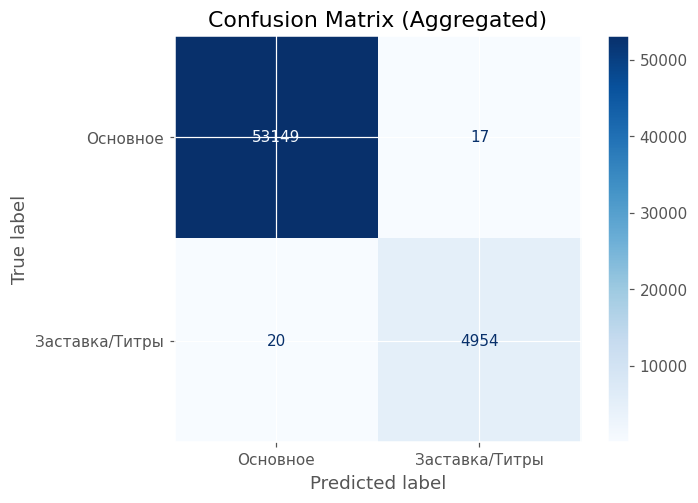

In [31]:
model.load_state_dict(torch.load(BEST_WEIGHTS))
model.eval()

# Загрузка меток
labels_df = pd.read_csv(LABELS_CSV)
labels_map = {
    pathlib.Path(row.file).stem: (
        int(hhmmss_to_sec(row.start_main)),
        int(hhmmss_to_sec(row.end_main))
    )
    for _, row in labels_df.iterrows()
}

# Результаты
metrics = {
    'start_mae': [],
    'end_mae': [],
    'start_abs_error': [],
    'end_abs_error': []
}
all_predictions = []

# Обработка видео
for npz_file in tqdm(list(CLIP_DIR.glob('*.npz')), desc="Оценка видео"):
    video_id = '_'.join(npz_file.stem.split('_')[1:-1])
    true_start, true_end = labels_map[video_id]

    with np.load(npz_file) as data:
        windows = data['windows']
        starts = data['start_indices']

    # Предсказание вероятностей
    probs = []
    for i in range(0, len(windows), 16):  # Пакетами по 16 окон
        batch = torch.tensor(windows[i:i + 16]).to(device)
        with torch.no_grad():
            batch_probs = model(batch).cpu().numpy()
        probs.extend(batch_probs)

    probs = np.concatenate(probs)  # (T,)

    # сглаживаем: mean(3 с) → median(7 с)
    probs = uniform_filter1d(probs, size=3)
    probs = median_filter(probs, size=7)
    # Постобработка
    smoothed_probs = np.asarray(median_filter(probs, size=5), dtype=float)

    # Поиск границ
    pred_start = int(find_transition(smoothed_probs, 'start'))
    pred_end = int(find_transition(smoothed_probs, 'end'))

    # Расчет ошибок
    start_error = abs(pred_start - true_start)
    end_error = abs(pred_end - true_end)

    # Сохранение результатов
    metrics['start_mae'].append(start_error)
    metrics['end_mae'].append(end_error)
    metrics['start_abs_error'].append(start_error)
    metrics['end_abs_error'].append(end_error)

    all_predictions.append({
        'video_id': video_id,
        'true_start': true_start,
        'pred_start': pred_start,
        'true_end': true_end,
        'pred_end': pred_end,
        'start_error': start_error,
        'end_error': end_error
    })

    # Визуализация для текущего видео
    plt.figure(figsize=(16, 6))

    # Основной график вероятностей
    plt.plot(smoothed_probs, label='Вероятность заставки/титров', color='blue', alpha=0.8)

    # Зоны заставки и титров
    plt.axvspan(0, pred_start, alpha=0.1, color='blue', label='Заставка (предсказано)')
    plt.axvspan(pred_end, len(smoothed_probs) - 1, alpha=0.1, color='red', label='Титры (предсказано)')
    plt.axvspan(true_start, true_end, alpha=0.05, color='green', label='Основной контент (истина)')

    # Вертикальные линии границ
    plt.axvline(true_start, color='green', linestyle='--', linewidth=2, label='Истинное начало')
    plt.axvline(pred_start, color='blue', linewidth=2, label='Предсказанное начало')
    plt.axvline(true_end, color='green', linestyle='--', linewidth=2, label='Истинный конец')
    plt.axvline(pred_end, color='red', linewidth=2, label='Предсказанный конец')

    # Вычисление порогов
    base = np.median(smoothed_probs)
    spread = mad(smoothed_probs)
    thr_s = base + 2 * spread
    thr_e = base + 2.5 * spread

    # Пороговые линии
    plt.axhline(thr_s, color='orange', linestyle=':', label=f'Порог заставки: {thr_s:.2f}')
    plt.axhline(thr_e, color='purple', linestyle=':', label=f'Порог титров: {thr_e:.2f}')
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)


    # Текстовые аннотации
    def sec_to_hhmmss(sec):
        h = int(sec // 3600)
        m = int((sec % 3600) // 60)
        s = int(sec % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"


    plt.text(true_start, 0.92, f' Начало (истина): {sec_to_hhmmss(true_start)}',
             color='green', fontsize=9, ha='right' if true_start > len(smoothed_probs) / 2 else 'left')
    plt.text(pred_start, 0.87, f' Начало (предск.): {sec_to_hhmmss(pred_start)}',
             color='blue', fontsize=9, ha='right' if pred_start > len(smoothed_probs) / 2 else 'left')
    plt.text(true_end, 0.82, f' Конец (истина): {sec_to_hhmmss(true_end)}',
             color='green', fontsize=9, ha='right' if true_end > len(smoothed_probs) / 2 else 'left')
    plt.text(pred_end, 0.77, f' Конец (предск.): {sec_to_hhmmss(pred_end)}',
             color='red', fontsize=9, ha='right' if pred_end > len(smoothed_probs) / 2 else 'left')

    # Статистика по видео
    video_length = len(smoothed_probs)
    main_content_percent = 100 * (true_end - true_start) / video_length
    stats_text = (f"Длина видео: {sec_to_hhmmss(video_length)}\n"
                  f"Основной контент: {sec_to_hhmmss(true_end - true_start)} ({main_content_percent:.1f}%)\n"
                  f"Заставка: {sec_to_hhmmss(true_start)}, Титры: {sec_to_hhmmss(video_length - true_end)}")

    plt.annotate(stats_text, xy=(0.98, 0.15), xycoords='axes fraction',
                 fontsize=9, ha='right', va='bottom',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Настройки оформления
    plt.title(f"{video_id} | Ошибка начала: {start_error}с | Ошибка конца: {end_error}с", fontsize=14)
    plt.xlabel('Время (секунды)')
    plt.ylabel('Вероятность')
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Сохраняем с высоким разрешением
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Место для легенды
    plt.savefig(RESULTS_DIR / f'prediction_{video_id}.png', dpi=150, bbox_inches='tight')
    plt.close()

# Расчет итоговых метрик
final_metrics = {
    'start_mae': np.mean(metrics['start_mae']),
    'end_mae': np.mean(metrics['end_mae']),
    'start_std': np.std(metrics['start_abs_error']),
    'end_std': np.std(metrics['end_abs_error']),
    'max_start_error': np.max(metrics['start_abs_error']),
    'max_end_error': np.max(metrics['end_abs_error']),
    'videos_processed': len(all_predictions)
}

# Confusion Matrix
all_targets = []
all_preds = []
for video in all_predictions:
    # Формирование бинарных масок для всего видео
    video_length = len(probs)  # Для упрощения демонстрации
    true_mask = np.zeros(video_length, dtype=int)
    true_mask[:video['true_start']] = 1
    true_mask[video['true_end']:] = 1

    pred_mask = np.zeros(video_length, dtype=int)
    pred_mask[:video['pred_start']] = 1
    pred_mask[video['pred_end']:] = 1

    all_targets.extend(true_mask)
    all_preds.extend(pred_mask)

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Основное', 'Заставка/Титры'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Aggregated)')
plt.savefig(RESULTS_DIR / 'confusion_matrix.png')

# Сохранение результатов
pd.DataFrame(all_predictions).to_csv(RESULTS_DIR / 'predictions.csv', index=False)
serializable_metrics = {}
for k, v in final_metrics.items():
    if isinstance(v, (np.integer,)):
        serializable_metrics[k] = int(v)
    elif isinstance(v, (np.floating,)):
        serializable_metrics[k] = float(v)
    else:
        serializable_metrics[k] = v

# Сохраняем
with open(METRICS_FILE, 'w') as f:
    json.dump(serializable_metrics, f, indent=2)

# Печатаем на экран
print("\nФинальные метрики:")
print(json.dumps(serializable_metrics, indent=2))

## Анализ результатов


Результаты оценки
Средняя ошибка начала: 0.47 ± 0.50 сек
Средняя ошибка конца: 1.63 ± 1.60 сек
Максимальная ошибка начала: 1 сек
Максимальная ошибка конца: 6 сек


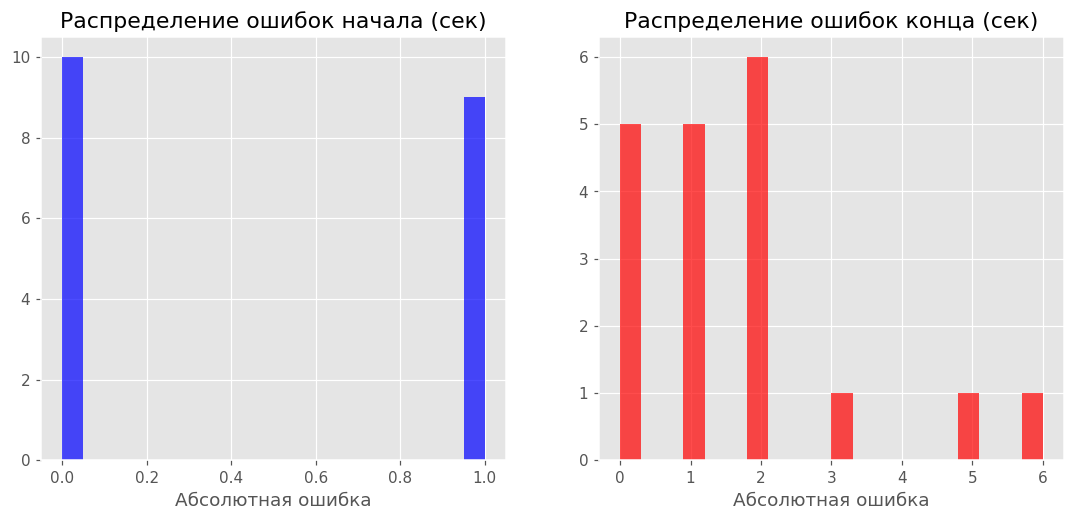

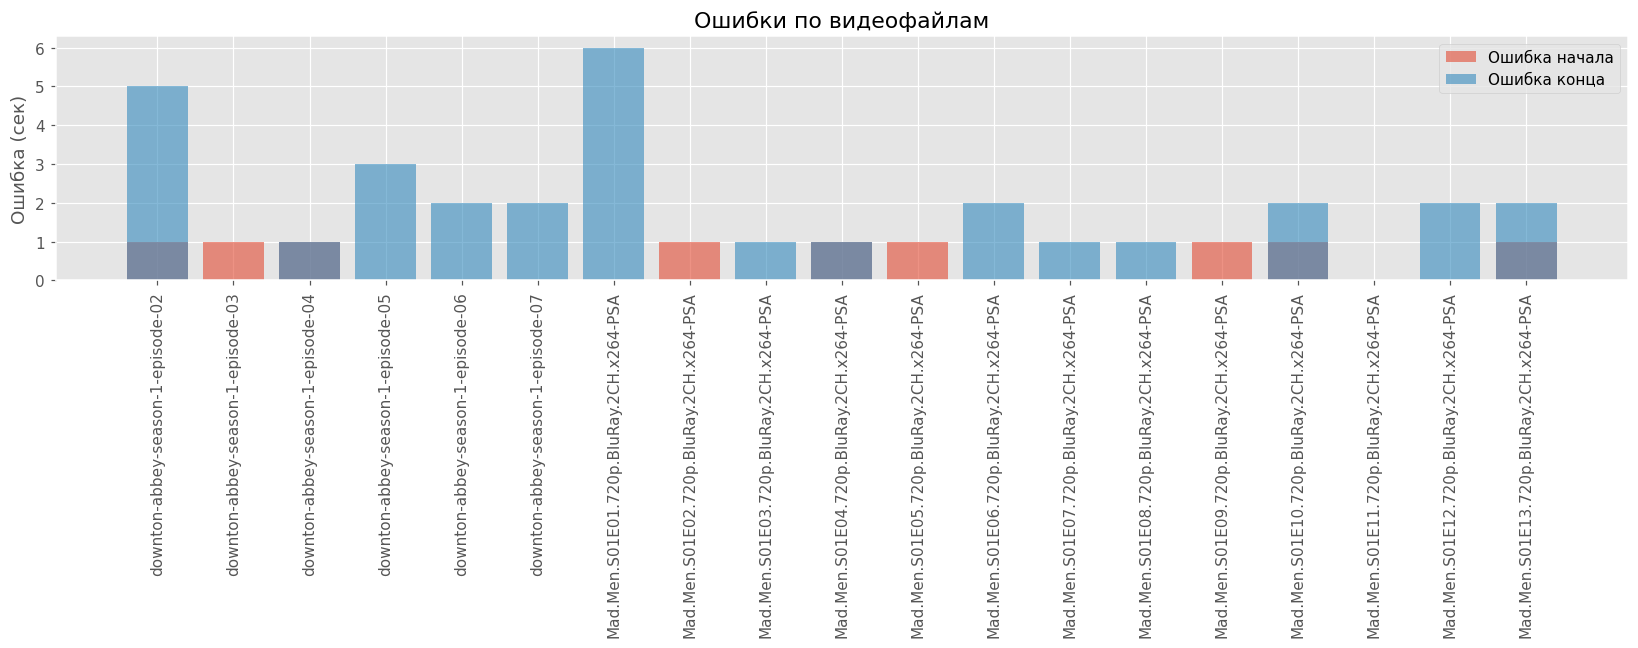

In [30]:
metrics = json.load(open(METRICS_FILE))
predictions = pd.read_csv(RESULTS_DIR / 'predictions.csv')

# Визуализация распределения ошибок
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(predictions['start_error'], bins=20, alpha=0.7, color='blue')
plt.title('Распределение ошибок начала (сек)')
plt.xlabel('Абсолютная ошибка')

plt.subplot(122)
plt.hist(predictions['end_error'], bins=20, alpha=0.7, color='red')
plt.title('Распределение ошибок конца (сек)')
plt.xlabel('Абсолютная ошибка')
plt.savefig(RESULTS_DIR / 'error_distribution.png')

# График ошибок по видео
plt.figure(figsize=(15, 6))
plt.bar(predictions['video_id'], predictions['start_error'],
        alpha=0.6, label='Ошибка начала')
plt.bar(predictions['video_id'], predictions['end_error'],
        alpha=0.6, label='Ошибка конца')
plt.xticks(rotation=90)
plt.ylabel('Ошибка (сек)')
plt.legend()
plt.title('Ошибки по видеофайлам')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'errors_per_video.png')

# Вывод метрик
print("\nРезультаты оценки")
print(f"Средняя ошибка начала: {metrics['start_mae']:.2f} ± {metrics['start_std']:.2f} сек")
print(f"Средняя ошибка конца: {metrics['end_mae']:.2f} ± {metrics['end_std']:.2f} сек")
print(f"Максимальная ошибка начала: {metrics['max_start_error']} сек")
print(f"Максимальная ошибка конца: {metrics['max_end_error']} сек")

# Анализ сложных случаев
hard_cases = predictions[
    (predictions['start_error'] > 10) |
    (predictions['end_error'] > 10)
    ]

if not hard_cases.empty:
    print("\nСложные случаи:")
    for _, row in hard_cases.iterrows():
        print(f"{row['video_id']}: начало +{row['start_error']}с, конец +{row['end_error']}с")

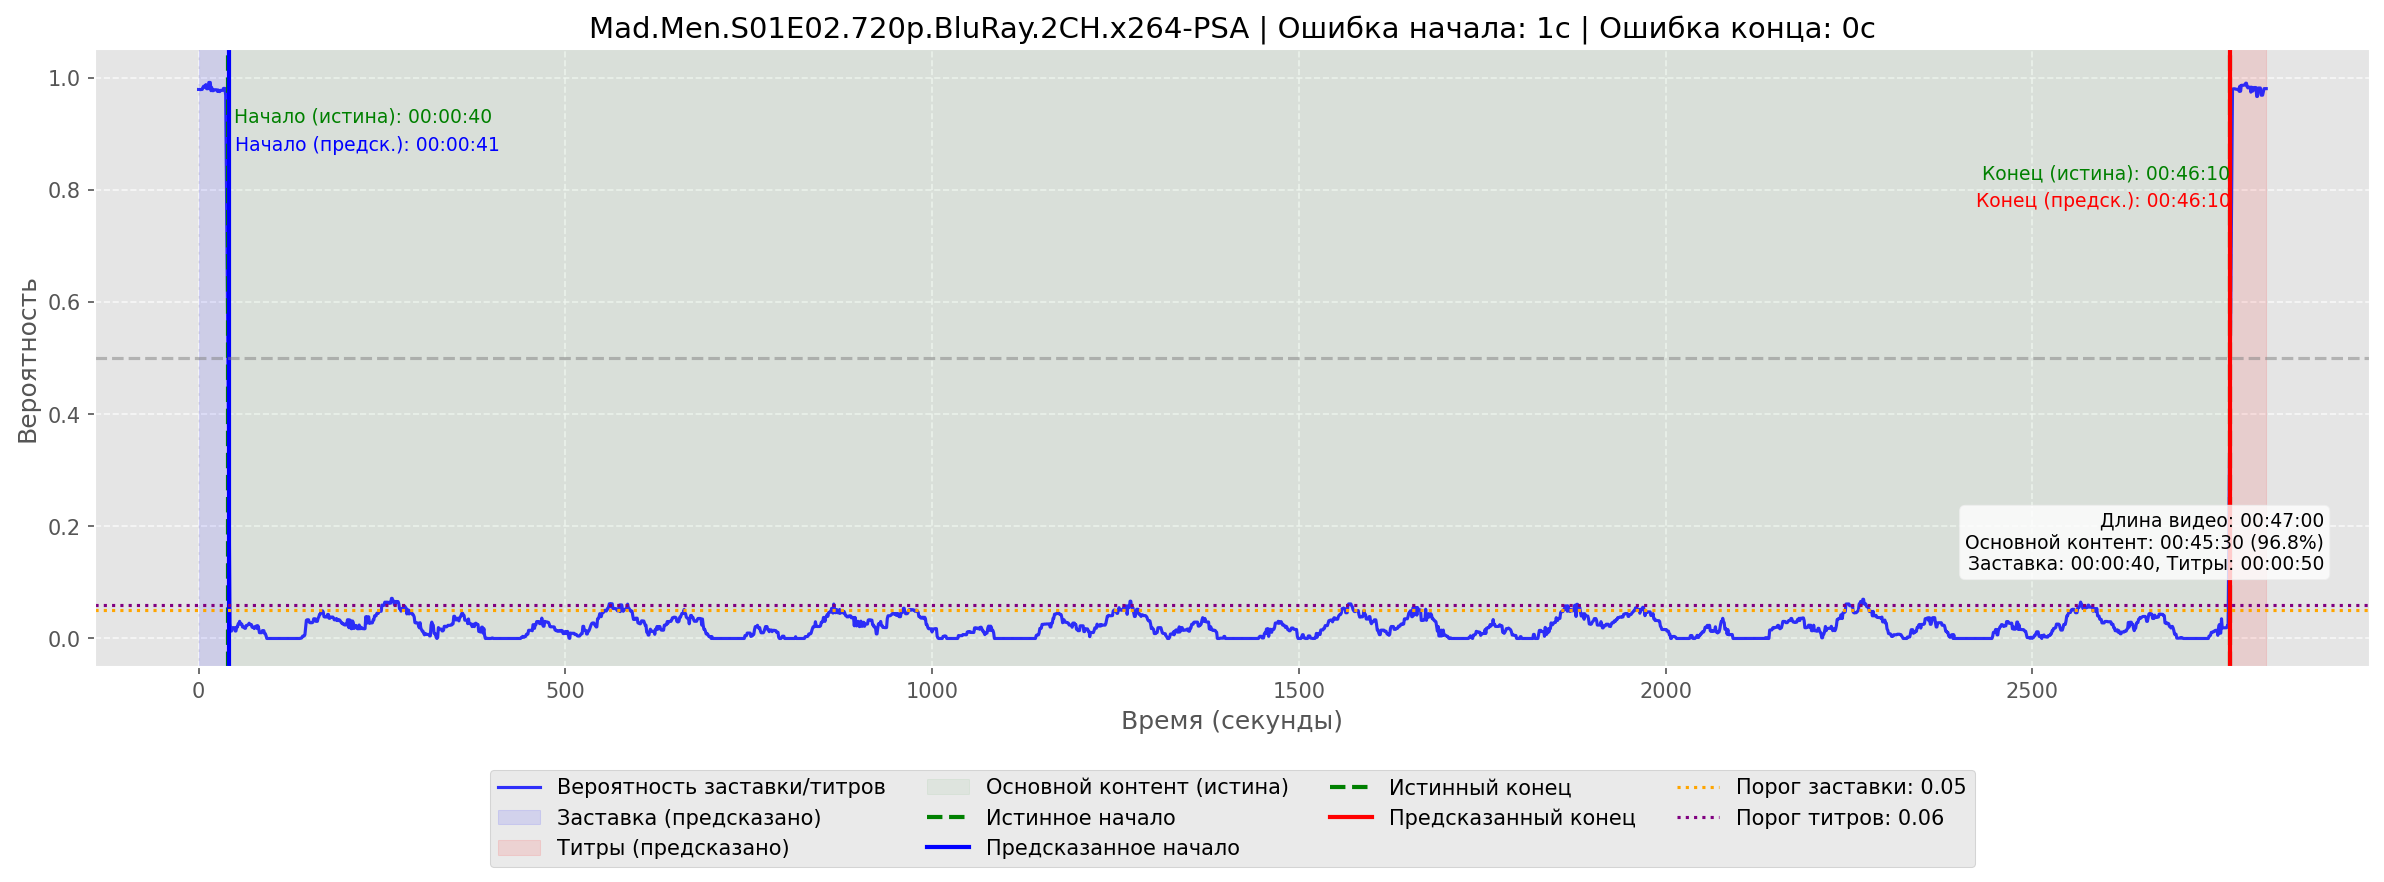

In [33]:
from IPython.display import Image, display

local_path = 'results/prediction_Mad.Men.S01E02.720p.BluRay.2CH.x264-PSA.png'
display(Image(filename=local_path, width=900))